# Homework #2

In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

## Problem 1

The first part of this assignment consists in studying a single particle performing
a continuous-time random walk in a fiven network

### a) 
What is, according to the simulations, the average time it takes a particle that starts in node a to leave the node and then return to it?

In [48]:
# Transition rate matrix
Lambda = np.array([
    [0, 2/5, 1/5, 0, 0],
    [0, 0, 3/4, 1/4, 0],
    [1/2, 0, 0, 1/3, 0],
    [0, 0, 1/3, 0, 2/3],
    [0, 1/2, 0, 1/3, 0]
])

# Nodes and their indices
nodes = ['o', 'a', 'b', 'c', 'd']
node_indices = {node: idx for idx, node in enumerate(nodes)}
inv_node_indices = {v: k for k, v in node_indices.items()}

# Compute global Poisson clock rate omega_star
omega = np.sum(Lambda, axis=1)
omega_star = np.max(omega)

# Compute transition probability matrix P_bar
P_ij = Lambda/omega_star 
P_ii = np.diag(np.ones(len(omega))-np.sum(P_ij,axis=1))
P_bar = P_ij + P_ii

In [24]:
### Return time simulation using global Poisson clock
def get_particle_simulation_time(source='a', target='a', num_simulations=10000):

    transition_times = []  # List to store transition times for each simulation

    for _ in range(num_simulations):

        current_node = node_indices[source]
        cumulative_time = 0.0

        while True:
            # Draw the next time step using an exponential distribution
            t_next = -np.log(np.random.rand()) / omega_star
            cumulative_time += t_next

            # Select the next node based on the transition probabilities
            next_node = np.random.choice(len(P_bar), p=P_bar[current_node, :])

            # Move the particle to the next node
            current_node = next_node

            # Check if the particle has returned to the target node
            if current_node == node_indices[target]:
                transition_times.append(cumulative_time)
                break

    # Compute and return the average return time
    return np.mean(transition_times)

print("Simulated average return time on node a:", get_particle_simulation_time())

Simulated average return time on node a: 6.036321877318136


### b) 
How does the result in a) compare to the theoretical return-time $E_a[T_a^+]$? (Include a description of how this is computed.)

In [25]:
### Compute the theoretical return-time Ea[Ta]
def compute_stationary_distribution(P):
    values, vectors = np.linalg.eig(P.T)
    index = np.argmax(values.real)  # Dominant eigenvalue (close to 1)
    pi = vectors[:, index].real
    pi = pi / np.sum(pi)  # Normalize to get probabilities
    return pi

pi_bar =  compute_stationary_distribution(P_bar)

# Theoretical return-time for node 'a'
node_a = node_indices['a']
E_a_T_a = 1 / (omega[node_a] * pi_bar[node_a])

print("Theoretical return-time Ea[T_a+]:", E_a_T_a)

Theoretical return-time Ea[T_a+]: 6.0588235294117645


In [ ]:
### Simulate many retun-times
simulation_value_list = []
num_simulations_list = range(100, 10000, 200)
for num in num_simulations_list:
    simulation_value_list.append(get_particle_simulation_time(num_simulations=num))

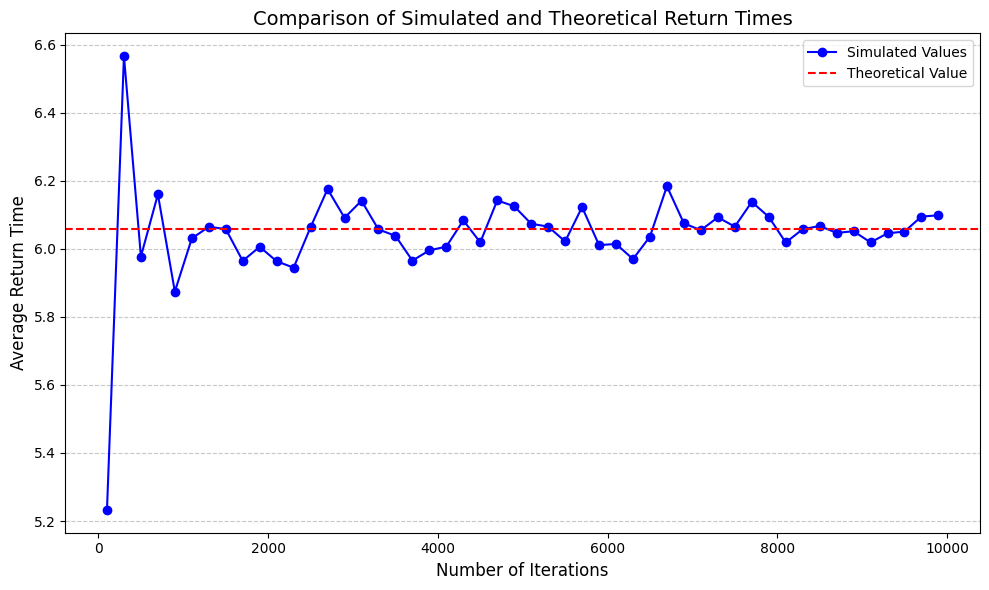

In [ ]:
### Plot the simulation results and compare with the theoretical value
plt.figure(figsize=(10, 6))
plt.plot(num_simulations_list, simulation_value_list, label='Simulated Values', marker='o', linestyle='-', color='blue')
plt.axhline(y=E_a_T_a, color='red', linestyle='--', label='Theoretical Value')

# Add labels, legend, and title
plt.xlabel('Number of Iterations', fontsize=12)
plt.ylabel('Average Return Time', fontsize=12)
plt.title('Comparison of Simulated and Theoretical Return Times', fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

### c) 

What is, according to the simulations, the average time it takes to move from node o to node d?

In [ ]:
### Hitting time simulation using global Poisson clock
simulated_hitting_time = get_particle_simulation_time(source='o', target='d')
print("Simulated average return time from node o to node d:", simulated_hitting_time)

Simulated average return time from node o to node d: 10.859661621241333


### d)
How does the result in c) compare to the theoretical hitting-time $E_o[T_d]$? (Describe also how this is computed.)

In [721]:
### Compute the theoretical hitting time Eo[Td]

# Remove the row and column corresponding to the target node 'd' from the transition matrix P_bar
target_node = node_indices['d']
P_reduced = np.delete(np.delete(P_bar, target_node, axis=0), target_node, axis=1)

# Solve the linear system for hitting times (excluding target node)
n = P_reduced.shape[0] 
I = np.eye(n)  
b = np.ones(n) / omega_star

# Compute the reduced hitting times h_reduced for all nodes except the target node 'd'
h_reduced = np.linalg.solve(I - P_reduced, b)

# Insert 0 for the target node 'd' (since the hitting time to itself is 0)
h = np.insert(h_reduced, target_node, 0)

# Theoretical hitting time from node 'o' to node 'd'
E_o_T_d = h[node_indices['o']] 

print("Theoretical hitting time Eo[Td]:", E_o_T_d)

Theoretical hitting time Eo[Td]: 10.766666666666667


In [548]:
### Simulate many hitting-times
simulation_value_list = []
num_simulations_list = range(100, 10000, 200)
for num in num_simulations_list:
    simulation_value_list.append(get_particle_simulation_time(source='o', target='d',num_simulations=num))

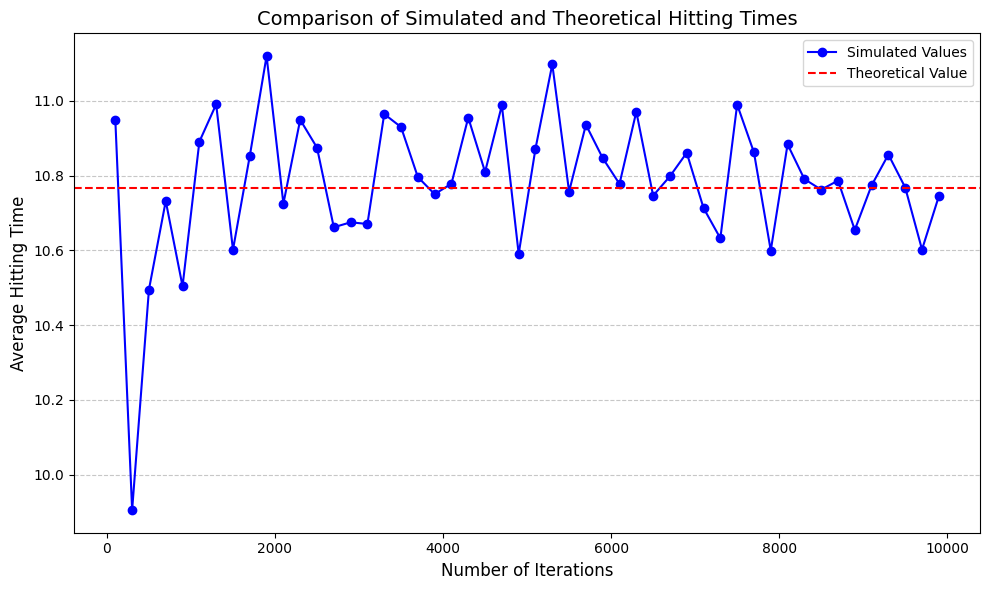

In [549]:
### Plot the simulation results and compare with the theoretical value
plt.figure(figsize=(10, 6))
plt.plot(num_simulations_list, simulation_value_list, label='Simulated Values', marker='o', linestyle='-', color='blue')
plt.axhline(y=E_o_T_d, color='red', linestyle='--', label='Theoretical Value')

# Add labels, legend, and title
plt.xlabel('Number of Iterations', fontsize=12)
plt.ylabel('Average Hitting Time', fontsize=12)
plt.title('Comparison of Simulated and Theoretical Hitting Times', fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

The next part of the exercise focuses on opinion dynamics.

### e)
Interpret the matrix Λ as the weight matrix of a graph $G=(V,E,\Lambda)$, and simulate the French-DeGroot dynamics on $G$ with an arbitrary initial condition $x(0)$. Does the dynamics converge to a consensus state for every initial condition $x(0)$? Motivate your answer.

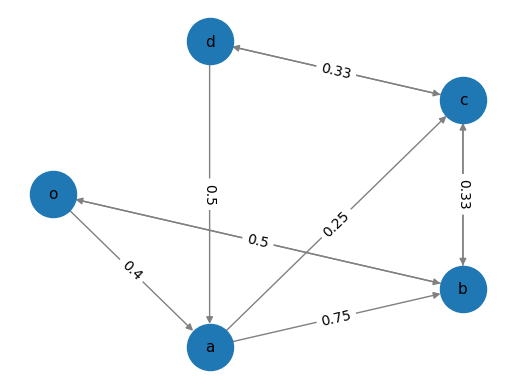

In [28]:
### Define the graph

# Create the graph from Lambda
def create_graph_from_lambda(Lambda, nodes):
    G = nx.DiGraph()
    for i, node in enumerate(nodes):
        for j, target in enumerate(nodes):
            if Lambda[i, j] > 0:  # Only add edges with non-zero weight
                G.add_edge(node, target, weight=round(Lambda[i, j], 2))
    return G

G = create_graph_from_lambda(Lambda, nodes)

# Plot the graph
def plot_graph(G):
    pos = nx.shell_layout(G)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(
        G,
        pos,
        edge_labels=labels,
        font_color='red',
        font_size=10
    )
    nx.draw(G, pos, with_labels=True, node_size=1100, font_size=11, edge_color='gray')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()

plot_graph(G)

In [29]:
### Check whether the graph is strongly connected 
if nx.is_strongly_connected(G):
    print("The graph is strongly connected.")
else:
    print("The graph is not strongly connected.")

The graph is strongly connected.


In [30]:
### Check whether the graph is aperiodic 
if nx.is_aperiodic(G):
    print("The graph is aperiodic")
else:
    print("The graph is not aperiodic")

The graph is aperiodic


In [31]:
### Check whether the French-DeGroot dynamics converge to a consensus state for every initial condition x(0)

# Compute transition matrix P
def compute_P(G):  
    A = nx.adjacency_matrix(G).toarray()  # Convert adjacency matrix to numpy array
    omega = np.sum(A, axis=1)  # Out-degree for each node
    D = np.diag(omega)
    return np.linalg.inv(D) @ A  # Row-stochastic matrix P

# Simulate French-DeGroot dynamics
def french_degroot(G, x0, steps=50):
    P = compute_P(G)
    opinions = x0
    opinions_over_time = [opinions]
    for _ in range(steps):
        opinions = P @ opinions  # Update opinions
        opinions_over_time.append(opinions)
    return np.array(opinions_over_time)

n_conditions = 100
n_consensus = 0

for _ in range(n_conditions):
    initial_opinions = np.random.rand(5)
    opinions_over_time = french_degroot(G, initial_opinions)
    opinions = opinions_over_time[-1]

    if np.allclose(opinions, opinions[0], atol=1e-8):
        n_consensus += 1

if n_consensus == n_conditions:
    print("The dynamics have converged to a consensus state.")
else:
    print("The dynamics did not converge to a consensus state.")

The dynamics have converged to a consensus state.


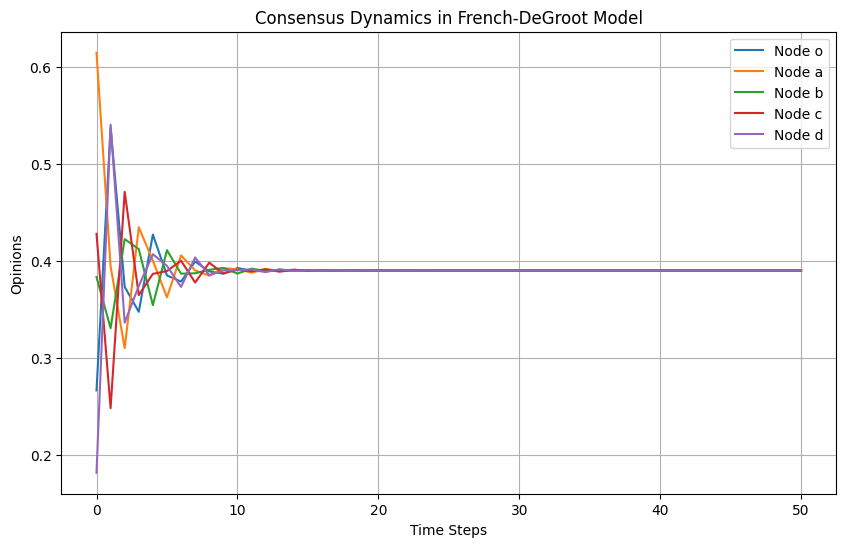

In [50]:
###  Plot the dynamics of the opinions over time for each node
plt.figure(figsize=(10, 6))
for i in range(opinions_over_time.shape[1]):
    plt.plot(opinions_over_time[:, i], label=f'Node {inv_node_indices[i]}')

plt.xlabel("Time Steps")
plt.ylabel("Opinions")
plt.title("Consensus Dynamics in French-DeGroot Model")
plt.legend()
plt.grid(True)
plt.show()

### f)
Assume that the initial state of the dynamics for each node $i \in V$ is given by $x_i(0) = ξ_i$, where $\{ξ_i\}_{i \in V}$ are independent random variables with variance
$$\sigma^2_a = \sigma^2_b =\sigma^2_c = 2, \sigma^2_o =\sigma^2_a = 1$$
Compute the variance of the consensus value, and compare your results with the numerical simulations.

In [ ]:
### Theoretical variance of the consensus

P = compute_P(G)
pi = compute_stationary_distribution(P)

variances = np.array([1, 2, 2, 2, 1])

theoretical_var = np.sum(pi**2 * variances)
print("Theoretical variance of the consensus:", theoretical_var)

Theoretical variance of the consensus: 0.37172601821558354


In [476]:
### Simulated variance of the consensus

num_simulations = 10000
consensus_values = []

for _ in range(num_simulations):
    # Generate random initial conditions based on given variances
    initial_opinions = np.random.normal(0, np.sqrt(variances))
    
    # Simulate to consensus
    opinions = french_degroot(G, initial_opinions)[-1]
    
    # Store consensus value
    consensus_values.append(opinions[0])  # Any index works as they're all equal

simulated_var = np.var(consensus_values)
print("Simulated variance of the consensus:", simulated_var)

Simulated variance of the consensus: 0.37378424833639945


### g) 
Remove the edges (d,a),(d,c),(a,c),(b,c). Describe and motivate the asymptotic behaviour of the dynamics. If the dynamics converges to an asymptotic state, how is such a state related to the initial condition x(0)?

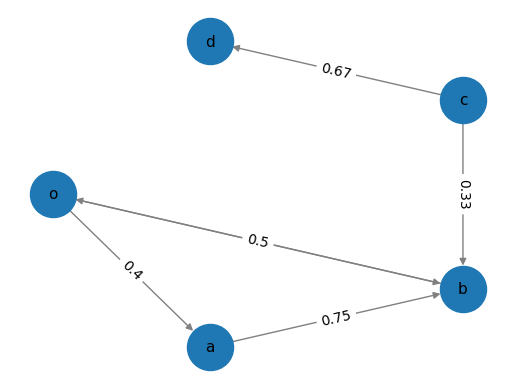

In [51]:
### Remove from G the following edges: (d,a),(d,c),(a,c),(b,c)
edges_to_remove_g = [('d', 'a'), ('d', 'c'), ('a', 'c'), ('b', 'c')]

G_modified_g = G.copy()
G_modified_g.remove_edges_from(edges_to_remove_g)
plot_graph(G_modified_g)

The graph is not strongly connected.


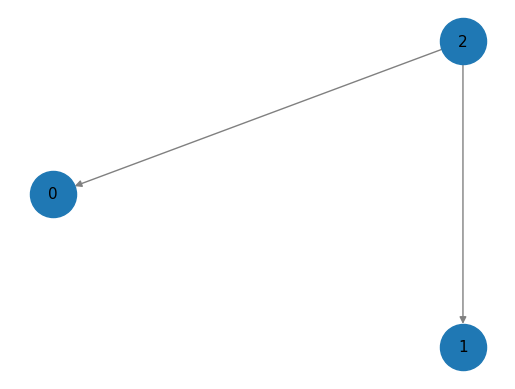

In [52]:
### Check whether the graph is strongly connected 
if nx.is_strongly_connected(G_modified_g):
    print("The graph is strongly connected.")
else:
    print("The graph is not strongly connected.")

# Plot the condensation graph
plot_graph(nx.condensation(G_modified_g))

In [53]:
### Check the SCCs 
sccs = list(nx.strongly_connected_components(G_modified_g))
print("Strongly Connected Components:", sccs)

# Verify influence structure
for scc in sccs:
    print(f"\nComponent {scc}:")
    scc_subgraph =  G_modified_g.subgraph(scc)
    if len(scc) > 1:  # Only check periodicity for components with more than one node
        if nx.is_aperiodic(scc_subgraph):
            print("The component is aperiodic")
        else:
            print("The component is not aperiodic")
    else:
        print("Single node component")
    print("Influenced by:", set.union(*[set(G_modified_g.predecessors(n)) - scc for n in scc]))
    print("Influences:", set.union(*[set(G_modified_g.successors(n)) - scc for n in scc]))

Strongly Connected Components: [{'a', 'b', 'o'}, {'d'}, {'c'}]

Component {'a', 'b', 'o'}:
The component is aperiodic
Influenced by: {'c'}
Influences: set()

Component {'d'}:
Single node component
Influenced by: {'c'}
Influences: set()

Component {'c'}:
Single node component
Influenced by: set()
Influences: {'b', 'd'}


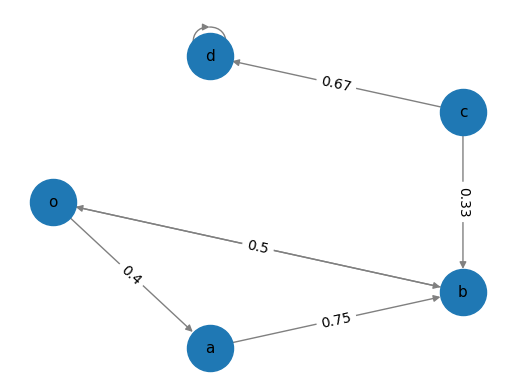

In [54]:
### Add a self loop on node 'd' since has out-degree 0
G_modified_g.add_edge('d','d')
plot_graph(G_modified_g)

In [ ]:
### Simulate the French-DeGroot dynamics
initial_opinions = np.random.rand(5)

opinions_over_time_g = french_degroot(G_modified_g, initial_opinions, steps=50)
opinions_modified_g = opinions_over_time_g[-1]
print("Inital opinions after removing edges (g):", initial_opinions)
print("Final opinions after removing edges (g):", opinions_modified_g)
if np.allclose(opinions_modified_g, opinions_modified_g[0], atol=1e-5):
    print("Dynamics (g) converged to a consensus state.")
else:
    print("Dynamics (g) did not converge to a consensus state.")

Inital opinions after removing edges (g): [0.79857822 0.37080596 0.86828313 0.62602917 0.90031357]
Final opinions after removing edges (g): [0.7177745  0.7177745  0.7177745  0.84007568 0.90031357]
Dynamics (g) did not converge to a consensus state.


In [ ]:
### Check whether:
# - the SCC (o,a,b) achives the consensus for every initial conditions x(0)
# - the opinion of node 'd' mantains a costant opinion over time

n_initial_conditions = 100
n_oab_consensus = 0
n_d_fixed = 0

for _ in range(n_initial_conditions):
    
    initial_opinions = np.random.rand(5)
    final_opinions = french_degroot(G_modified_g, initial_opinions, steps=100)[-1]

    # Check if node 'd' maintains a constant opinion over time
    if final_opinions[-1] == initial_opinions[-1]:
        n_d_fixed += 1
    
    # Check if all nodes in the SCC (o, a, b) reach consensus
    oab_opinions = final_opinions[:3]
    if all(abs(c - oab_opinions[0]) < 1e-8 for c in oab_opinions):
        n_oab_consensus += 1

# Check if node 'd' maintained a fixed opinion for all initial conditions
if n_initial_conditions == n_d_fixed:
    print("The opinion of node 'd' remained constant over all initial conditions.")
else:
    print(f"The opinion of node 'd' did not remain constant for {n_initial_conditions - n_d_fixed} initial conditions.")
    
# Check if the SCC (o, a, b) achieved consensus for all initial conditions
if n_initial_conditions == n_oab_consensus:
    print("The SCC (o, a, b) achieved consensus for every initial condition.")
else:
    print(f"The SCC (o, a, b) did not achieve consensus for {n_initial_conditions - n_oab_consensus} initial conditions.")

The opinion of node 'd' remained constant over all initial conditions.
The SCC (o, a, b) achieved consensus for every initial condition.


In [ ]:
### Check if when opinion_d = 0, opinion_c ≈ 1/3 of the consensus value of SCC (o, a, b)

n_initial_conditions = 100
n_satisfied_conditions = 0

for _ in range(n_initial_conditions):
    
    initial_opinions = np.random.rand(4)
    initial_opinions = np.concat((initial_opinions, [0]))
    
    final_opinions = french_degroot(G_modified_g, initial_opinions, steps=100)[-1]

    # Extract consensus opinion of SCC (o, a, b) and opinion of node c
    oab_opinions = final_opinions[0]
    c_opinion = final_opinions[3]
    
    # Check if opinion of c ≈ 1/3 of consensus value of SCC (o, a, b)
    if abs(c_opinion - oab_opinions/3) <= 1e-2:
        n_satisfied_conditions += 1
    

# Check if c_opinion ≈ 1/3 of the consensus value of scc o a b 
if n_initial_conditions == n_satisfied_conditions:
    print("If the initial opinion of node 'd' is 0, the final opinion of node 'c' \nis approximately one-third of the consensus value of the SCC (o, a, b)\nfor all initial conditions.")
else:
    print(f"Condition not satisfied for {n_initial_conditions - n_satisfied_conditions} initial conditions.")

If the initial opinion of node 'd' is 0, the final opinion of node 'c' 
is approximately one-third of the consensus value of the SCC (o, a, b)
for all initial conditions.


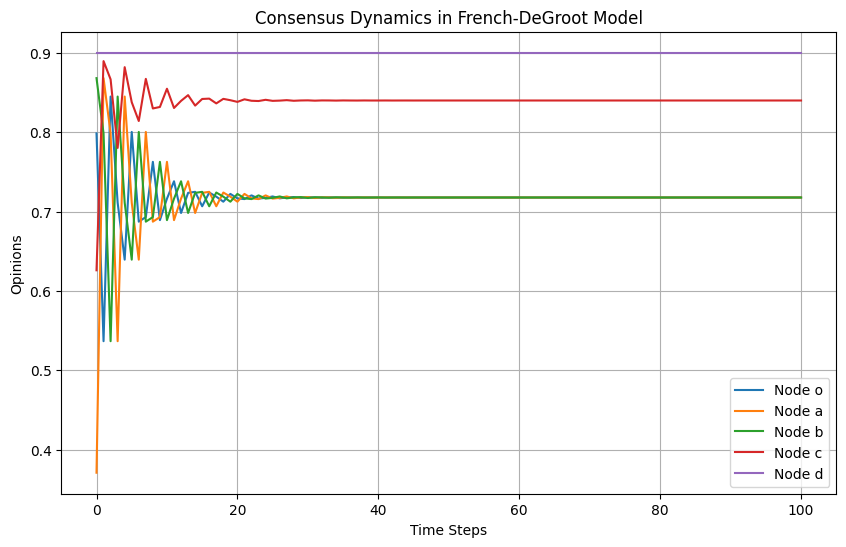

In [59]:
###  Plot the dynamics of the opinions over time for each node
plt.figure(figsize=(10, 6))
for i in range(opinions_over_time_g.shape[1]):
    plt.plot(opinions_over_time_g[:, i], label=f'Node {inv_node_indices[i]}')

plt.xlabel("Time Steps")
plt.ylabel("Opinions")
plt.title("Consensus Dynamics in French-DeGroot Model")
plt.legend()
plt.grid(True)
plt.show()

### h) 
Consider the graph (V,E,Λ), and remove the edges (b,o) and (d,a). Analyse the French-DeGroot dynamics on the new graph. In particular, describe how the asymptotic behaviour of the dynamics varies in terms of the initial condition x(0), and motivate your answer.

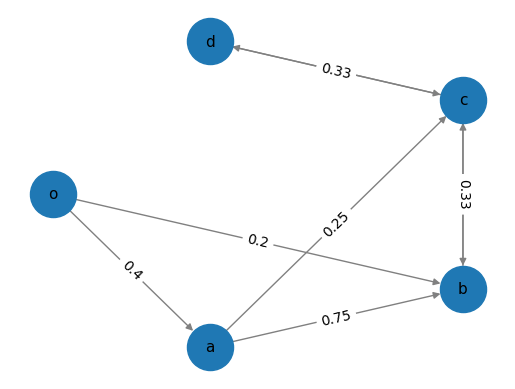

In [60]:
### Remove from G the following edges: (b,o), (d,a)
edges_to_remove_h = [('b', 'o'), ('d', 'a')]

G_modified_h = G.copy()
G_modified_h.remove_edges_from(edges_to_remove_h)
plot_graph(G_modified_h)

The graph is not strongly connected.


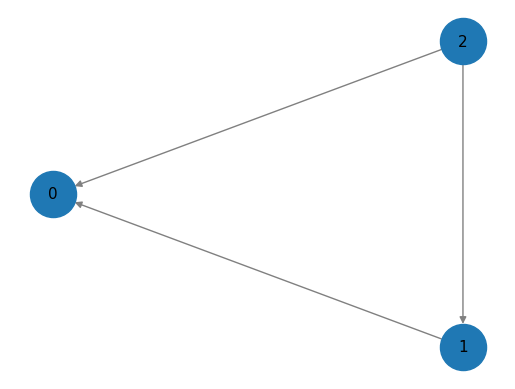

In [61]:
### Check whether the graph is strongly connected 
if nx.is_strongly_connected(G_modified_h):
    print("The graph is strongly connected.")
else:
    print("The graph is not strongly connected.")

# Plot the condensation graph
plot_graph(nx.condensation(G_modified_h))

In [62]:
### Check the SCCs 
sccs = list(nx.strongly_connected_components(G_modified_h))
print("Strongly Connected Components:", sccs)

# Verify influence structure
for scc in sccs:
    print(f"\nComponent {scc}:")
    scc_subgraph =  G_modified_h.subgraph(scc)
    if len(scc) > 1:  # Only check periodicity for components with more than one node
        if nx.is_aperiodic(scc_subgraph):
            print("The component is aperiodic")
        else:
            print("The component is not aperiodic")
    else:
        print("Single node component")
    print("Influenced by:", set.union(*[set(G_modified_h.predecessors(n)) - scc for n in scc]))
    print("Influences:", set.union(*[set(G_modified_h.successors(n)) - scc for n in scc]))

Strongly Connected Components: [{'c', 'b', 'd'}, {'a'}, {'o'}]

Component {'c', 'b', 'd'}:
The component is not aperiodic
Influenced by: {'a', 'o'}
Influences: set()

Component {'a'}:
Single node component
Influenced by: {'o'}
Influences: {'c', 'b'}

Component {'o'}:
Single node component
Influenced by: set()
Influences: {'a', 'b'}


In [70]:
### Simulate the French-DeGroot dynamics
initial_opinions = np.random.rand(5)
opinions_over_time_h = french_degroot(G_modified_h, initial_opinions, steps=100)
opinions_modified_h = opinions_over_time_h[-1]
print("Inital opinions after removing edges (h):", initial_opinions)
print("Final opinions after removing edges (h):", opinions_modified_h)
if np.allclose(opinions_modified_g, opinions_modified_g[0], atol=1e-5):
    print("Dynamics (h) converged to a consensus state.")
else:
    print("Dynamics (h) did not converge to a consensus state.")

Inital opinions after removing edges (h): [0.90388665 0.56977777 0.21335154 0.58702986 0.30328816]
Final opinions after removing edges (h): [0.43031947 0.50867467 0.27360908 0.58702986 0.27360908]
Dynamics (h) did not converge to a consensus state.


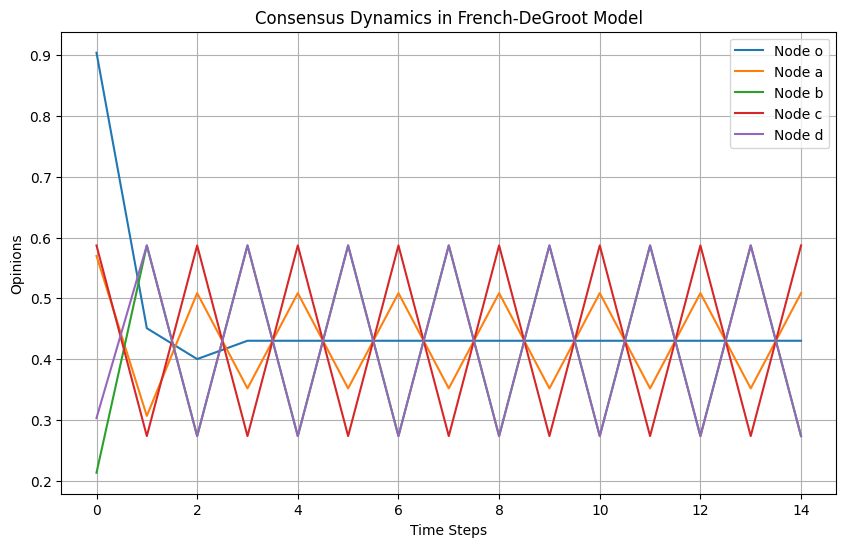

In [ ]:
###  Plot the dynamics of the opinions over time for each node (zoom)
plt.figure(figsize=(10, 6))
for i in range(opinions_over_time_h.shape[1]):
    plt.plot(opinions_over_time_h[:15, i], label=f'Node {inv_node_indices[i]}')

plt.xlabel("Time Steps")
plt.ylabel("Opinions")
plt.title("Consensus Dynamics in French-DeGroot Model")
plt.legend()
plt.grid(True)
plt.show()

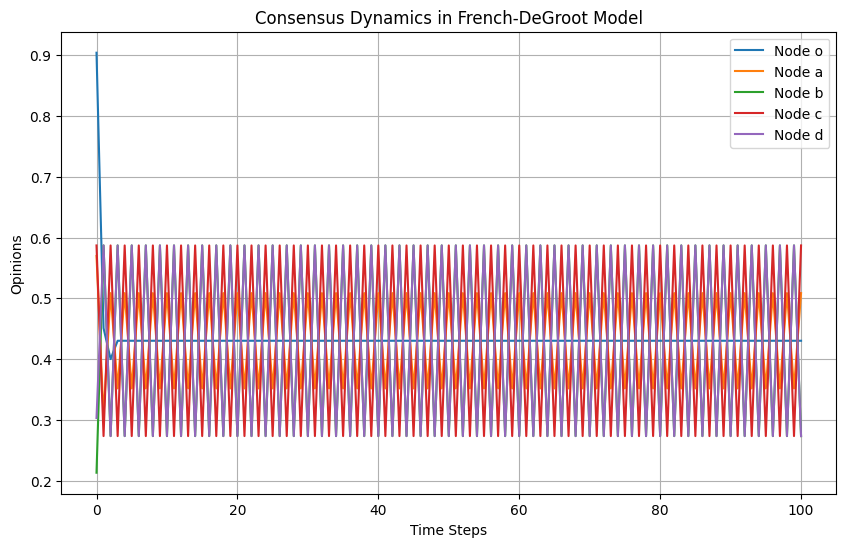

In [74]:
###  Plot the dynamics of the opinions over time for each node
plt.figure(figsize=(10, 6))
for i in range(opinions_over_time_h.shape[1]):
    plt.plot(opinions_over_time_h[:, i], label=f'Node {inv_node_indices[i]}')

plt.xlabel("Time Steps")
plt.ylabel("Opinions")
plt.title("Consensus Dynamics in French-DeGroot Model")
plt.legend()
plt.grid(True)
plt.show()

In [110]:
### Simulate the French-DeGroot dynamics (Limit case)
initial_opinions = np.array([0.2,1,0.5,0.5,0.5])
opinions_over_time_h = french_degroot(G_modified_h, initial_opinions, steps=100)
opinions_modified_h = opinions_over_time_h[-1]
print("Inital opinions after removing edges (h):", initial_opinions)
print("Final opinions after removing edges (h):", opinions_modified_h)
if np.allclose(opinions_modified_g, opinions_modified_g[0], atol=1e-5):
    print("Dynamics (h) converged to a consensus state.")
else:
    print("Dynamics (h) did not converge to a consensus state.")

Inital opinions after removing edges (h): [0.2 1.  0.5 0.5 0.5]
Final opinions after removing edges (h): [0.5 0.5 0.5 0.5 0.5]
Dynamics (h) did not converge to a consensus state.


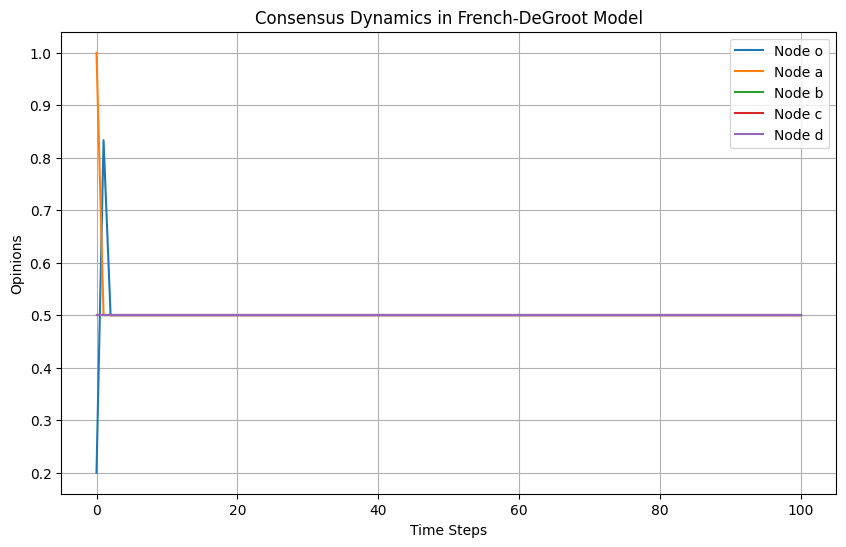

In [111]:
###  Plot the dynamics of the opinions over time for each node
plt.figure(figsize=(10, 6))
for i in range(opinions_over_time_h.shape[1]):
    plt.plot(opinions_over_time_h[:, i], label=f'Node {inv_node_indices[i]}')

plt.xlabel("Time Steps")
plt.ylabel("Opinions")
plt.title("Consensus Dynamics in French-DeGroot Model")
plt.legend()
plt.grid(True)
plt.show()

## Problem 2

In [ ]:
Lambda = np.array([
    [0, 2/5, 1/5, 0, 0],
    [0, 0, 3/4, 1/4, 0],
    [1/2, 0, 0, 1/3, 0],
    [0, 0, 1/3, 0, 2/3],
    [0, 1/2, 0, 1/3, 0]
])

# Nodes and their indices
nodes = ['o', 'a', 'b', 'c', 'd']
node_indices = {node: idx for idx, node in enumerate(nodes)}

# Compute omega_star
omega = np.sum(Lambda, axis=1)
omega_star = np.max(omega)

# compute P_bar
P_ij = Lambda/omega_star 
P_ii = np.diag(np.ones(len(omega))-np.sum(P_ij,axis=1))
P_bar = P_ij + P_ii

# compute pi_bar 
pi_bar = compute_stationary_distribution(P_bar)

# compute P
D = np.diag(omega)
P = np.linalg.inv(D) @ Lambda

### a) Particle perspective:
* If N = 100 particles all start in node a, what is the average time for a particle to return to node a?
* How does this compare to the answer in Problem 1, why?

In [ ]:
### Simulate the average return-time of 100 particles (global Poisson clock)
def simulate_particle_perspective(source='a', target='a', N=100, num_simulations=10000):

    # Transition probability matrix P_bar and node indices are assumed to be defined globally
    transition_times = []  # To store return times for each simulation

    for _ in range(num_simulations):
        # Initialize all particles at the source node
        particle_positions = [node_indices[source]] * N
        
        # Track which particles have visited the target node
        particles_reached_target = [False] * N
        
        cumulative_time = 0.0

        while True:
            # Increment the global Poisson clock: rate is N * omega_star
            t_next = -np.log(np.random.rand()) / (N * omega_star)
            cumulative_time += t_next

            # Filter particles that have not yet reached the target node
            active_particles = [i for i in range(N) if not particles_reached_target[i]]

            # Randomly select one particle from the active particles
            particle_to_move = np.random.choice(active_particles)

            # Move the particle to the next node based on transition probabilities
            current_node = particle_positions[particle_to_move]
            next_node = np.random.choice(len(P_bar), p=P_bar[current_node, :])
            particle_positions[particle_to_move] = next_node

            # Update if the particle has reached the target node
            if next_node == node_indices[target]:
                particles_reached_target[particle_to_move] = True

            # Check if all particles have reached the target node at least once
            if all(particles_reached_target):
                transition_times.append(cumulative_time)
                break

    # Return the average return time over all simulations
    return np.mean(transition_times)

average_return_time = simulate_particle_perspective()
print(f"Tempo medio di ritorno per 100 particelle: {average_return_time}")

Tempo medio di ritorno per 100 particelle: 6.058961299690012


### b) Node perspective:
* If N = 100 particles start in node a, and the system is simulated for 60 time units, what is the average number of particles in the diﬀerent nodes at the end of the simulation?
* Illustrate the simulation above with a plot showing the number of particles in each node during the simulation time.
* Compare the simulation result in the first point above with the stationary distribution of the continuous-time random walk followed by the single particles.

In [ ]:
### Simulate the number of particles for each node through the time (global Poisson clock)
def simulate_node_perspective(source='a', simulation_time=60, N=100):

    # Initialize particle counts: all particles start at the given node
    node_counts = {node: 0 for node in nodes}
    node_counts[source] = N

    # Time variables
    current_time = 0
    time_points = [0]
    count_history = [node_counts.copy()]

    #departing_node = source (node-level Poisson clock)
    while current_time < simulation_time:
        # Calculate departure rates for each node
        #departure_rates = [node_counts[node] * omega[node_indices[node]] for node in nodes] (node-level Poisson clock)
        departure_rates = [node_counts[node] * omega_star for node in nodes]

        # Generate next event time (Global Poisson clock)
        #next_time = -np.log(np.random.random()) / (N * omega[node_indices[departing_node]])  (node-level Poisson clock)
        next_time = -np.log(np.random.random()) / (N * omega_star) 
        current_time += next_time

        # Choose a node where a particle will depart (proportionally to departure rates)
        
        node_probs = [rate / sum(departure_rates) for rate in departure_rates]
        departing_node = np.random.choice(nodes, p=node_probs)

        # Choose a neighboring node based on transition probabilities
        if node_counts[departing_node] > 0:
            #next_node = np.random.choice(nodes, p=P[node_indices[departing_node]]) (node-level Poisson clock)
            next_node = np.random.choice(nodes, p=P_bar[node_indices[departing_node]])
            node_counts[departing_node] -= 1
            node_counts[next_node] += 1

        # Track counts over time
        count_history.append(node_counts.copy())
        time_points.append(current_time)

    return node_counts, count_history, time_points

### Plot node evolution function 
def plot_node_evolution(count_history, time_points):
    """
    Plot the evolution of particle counts in each node over time.
    """
    plt.figure(figsize=(12, 6))
    for node in nodes:
        counts = [state[node] for state in count_history]
        plt.plot(time_points, counts, label=f'Node {node}')
    
    plt.xlabel('Time')
    plt.ylabel('Number of Particles')
    plt.title('Evolution of Particle Counts in Nodes')
    plt.legend()
    plt.grid(True)
    plt.show()


Node Perspective Results:
Final number of particles in each node:
Node o: 27
Node a: 14
Node b: 24
Node c: 19
Node d: 16

Expected stationary distribution (N * pi_bar):
Node o: 23.06
Node a: 16.50
Node b: 27.67
Node c: 18.20
Node d: 14.56


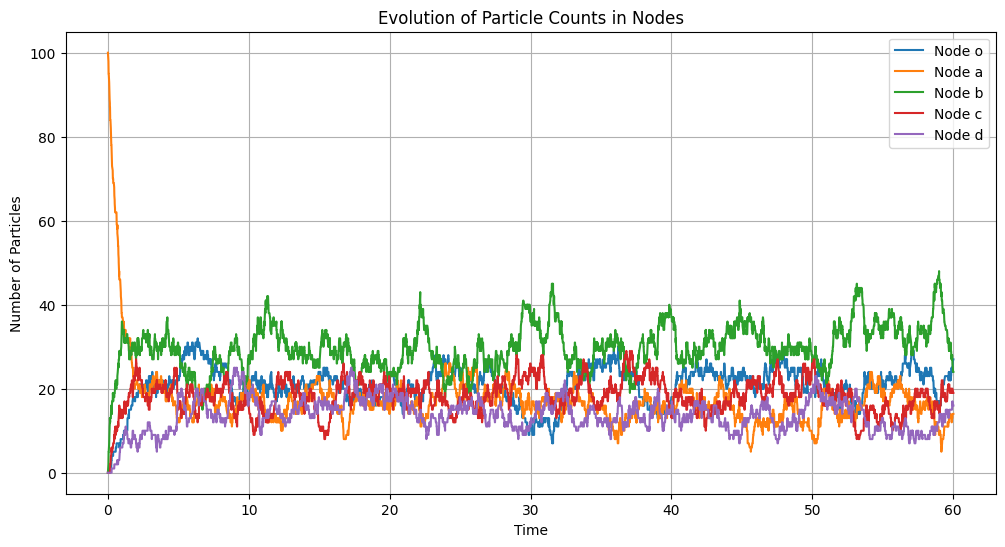

In [ ]:
N=100
# Run Node Perspective Simulation
final_state, count_history, time_points = simulate_node_perspective(simulation_time=60, N=N)

# Display Final Results
print(f"\nNode Perspective Results:")
print("Final number of particles in each node:")
for node, count in final_state.items():
    print(f"Node {node}: {count}")

# Expected stationary distribution
expected_counts = N * pi_bar
print("\nExpected stationary distribution (N * pi_bar):")
for node, expected_count in zip(nodes, expected_counts):
    print(f"Node {node}: {expected_count:.2f}")

# Plot evolution of particle counts
plot_node_evolution(count_history, time_points)

## Problem 3

In [77]:
# Define transition rate matrix
Lambda_open = np.array([
    [0, 3/4, 3/4, 0, 0],
    [0, 0, 1/4, 1/4, 2/4],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0]
])

# Calculate omega (total outgoing rates)
omega = np.sum(Lambda_open, axis=1)
omega[4] = 2  # Set exit rate for node d

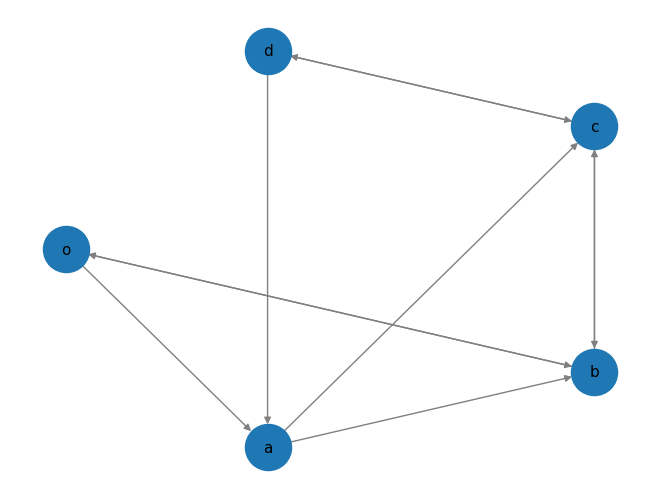

In [ ]:
# Create a graph
G_open = create_graph_from_lambda(Lambda=Lambda_open, nodes=nodes)

# Plot
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1100, font_size=11, edge_color='gray')
plt.show()

### a) Proportional rate:
* Simulate the system for 60 time units and plot the evolution of the number of particles in each node over time with input rate λ= 100.
* What is the largest input rate that the system can handle without blowing up?

In [ ]:
### Simulates an open network with a proportional rate
def simulate_proportional_rate(input_rate, simulation_time):
    """
    Simulate open network with proportional rate scenario.
    """
    # Initialize particle counts
    node_counts = {node: 0 for node in nodes}
    current_time = 0
    time_points = [0]
    count_history = [node_counts.copy()]
    
    while current_time < simulation_time:
        # Calculate total rate (input rate + sum of node rates)
        node_rates = [node_counts[node] * omega[node_indices[node]] for node in nodes]
        total_rate = input_rate + sum(node_rates)

        # Generate next event time
        next_time = -np.log(np.random.random()) / total_rate
        current_time += next_time
        
        # Determine if it's an input event or node event
        event_probs = [input_rate] + node_rates
        event_probs = [p/total_rate for p in event_probs]
        event = np.random.choice(len(event_probs), p=event_probs)
        
        if event == 0:  # Input event
            node_counts['o'] += 1
        else:  # Node event
            node = nodes[event-1]
            if node_counts[node] > 0:
                if node == 'd':  # Exit from system
                    node_counts[node] -= 1
                else:  # Move to next node
                    probs = Lambda_open[node_indices[node]] / omega[node_indices[node]]
                    next_node = np.random.choice(nodes, p=probs)
                    node_counts[node] -= 1
                    node_counts[next_node] += 1
        
        count_history.append(node_counts.copy())
        time_points.append(current_time)
    
    return count_history, time_points

In [ ]:
### Plots the evolution of particle counts in each node over time
def plot_evolution(count_history, time_points, title):
    """
    Plot the evolution of particle counts in each node over time.
    """
    plt.figure(figsize=(12, 6))
    for node in nodes:
        counts = [state[node] for state in count_history]
        plt.plot(time_points, counts, label=f'Node {node}')
    
    plt.xlabel('Time')
    plt.ylabel('Number of Particles')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

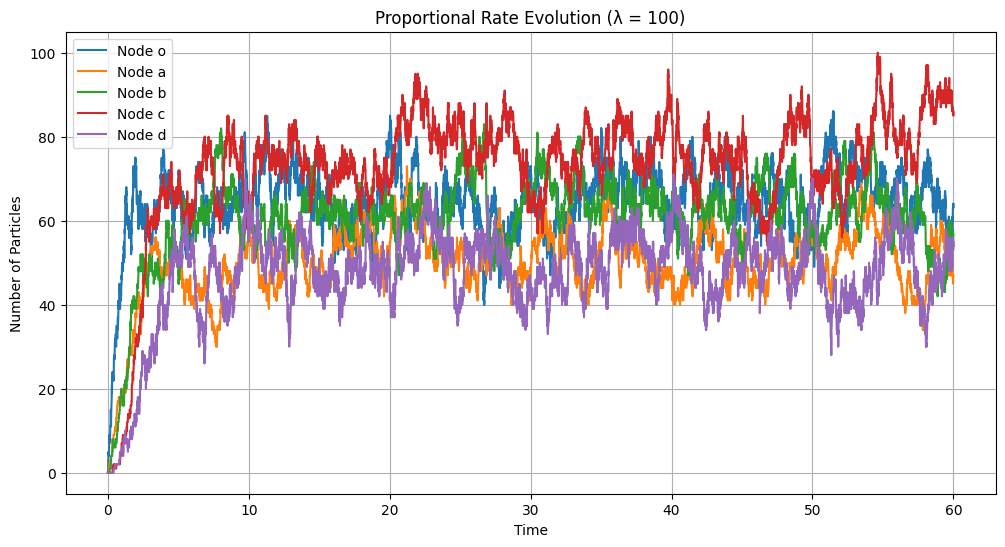

In [83]:
# Proportional rate with λ = 100
prop_history, prop_time = simulate_proportional_rate(100, 60)
plot_evolution(prop_history, prop_time, 'Proportional Rate Evolution (λ = 100)')

Finding unstable lambda for proportional rate...
Proportional Rate: Stable for λ = 50


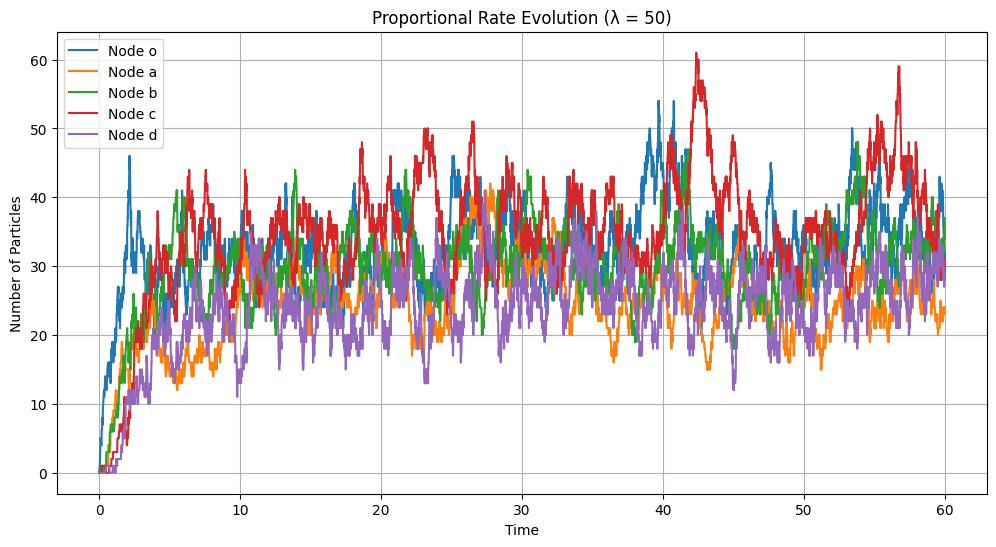

Proportional Rate: Stable for λ = 100


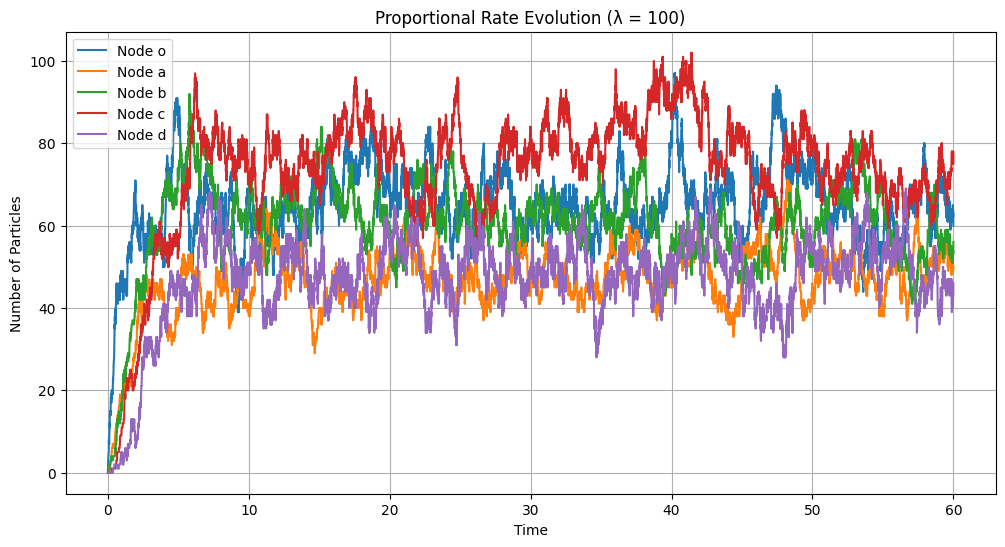

Proportional Rate: Stable for λ = 200


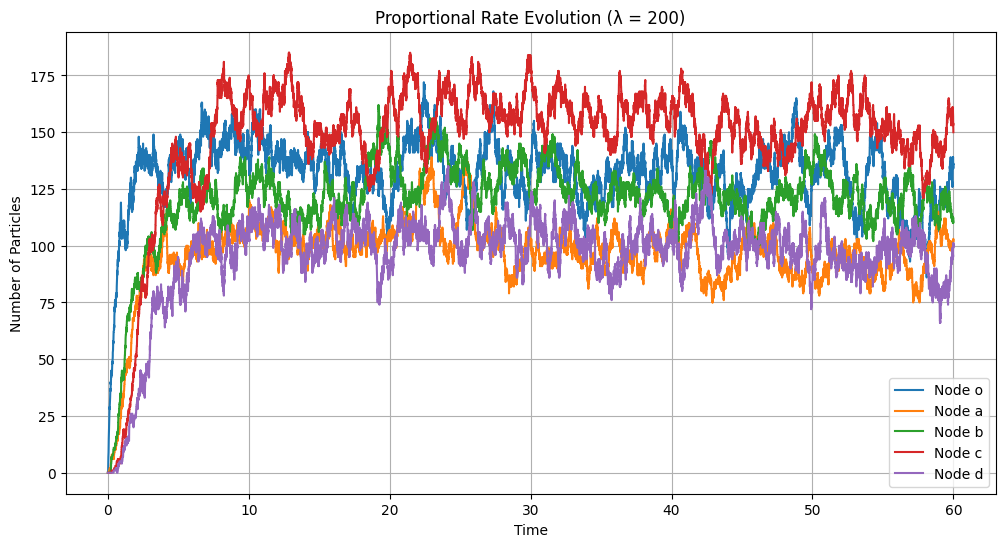

Proportional Rate: Stable for λ = 400


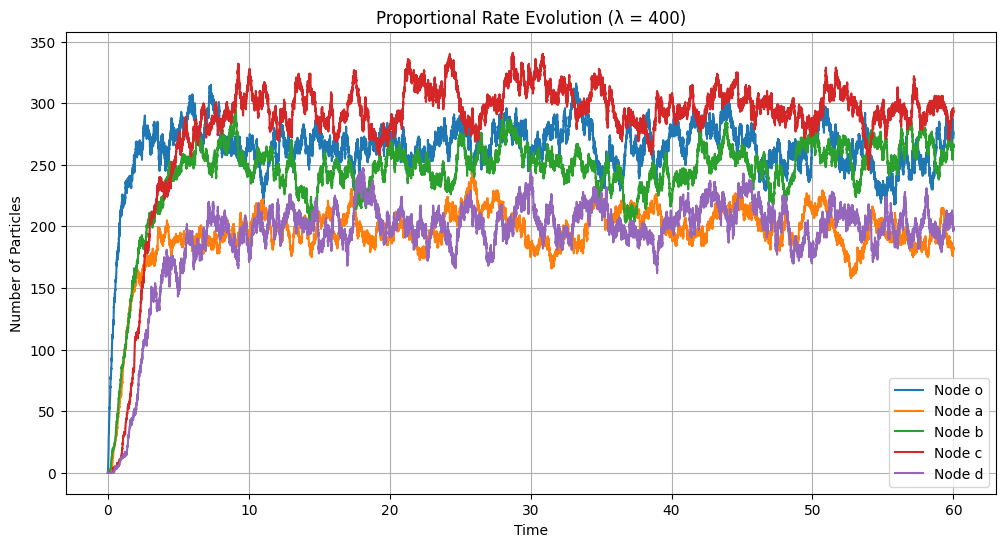

Proportional Rate: Stable for λ = 800


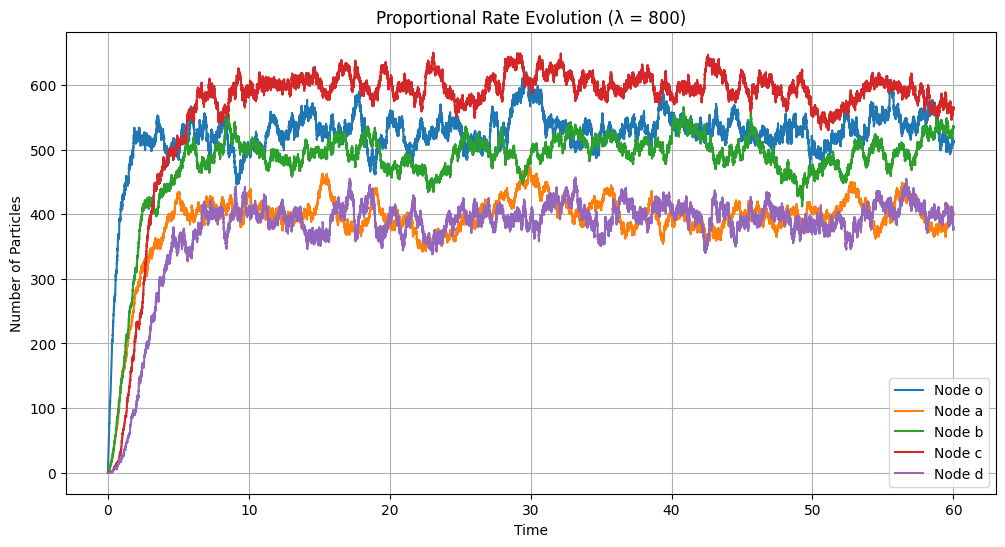

The system's proportional rate mechanism effectively self-regulates, avoiding instability


In [109]:
### Find the largest input rate for proportional rate before system instability
def find_unstable_lambda_proportional(simulation_time):
    
    lambdas = [50, 100, 200, 400, 800] # Test input rates
    
    for input_rate in lambdas:
        history, time_points = simulate_proportional_rate(input_rate, simulation_time)
        
        # Count particles entering node 'o' and exiting node 'd'
        particles_in_o = sum(state['o'] for state in history)
        particles_out_d = sum(state['d'] for state in history)
        
        # Check instability condition
        if particles_out_d > 0 and particles_in_o / particles_out_d > 100:
            print(f"Proportional Rate: System blows up at λ = {input_rate} (In/Out Ratio > 100)")
            break
        
        print(f"Proportional Rate: Stable for λ = {input_rate}")
        plot_evolution(history, time_points, f'Proportional Rate Evolution (λ = {input_rate})')

simulation_time = 60
print("Finding unstable lambda for proportional rate...")
find_unstable_lambda_proportional(simulation_time)
print("The system's proportional rate mechanism effectively self-regulates, avoiding instability")

### b) Fixed rate:
* Simulate the system for 60 time units and plot the evolution of number of particles in each node over time with input rate λ= 1.
* What is the largest input rate that the system can handle without blowing up? Motivate your answer

In [ ]:
### Simulates an open network with a fixed rate
def simulate_fixed_rate(input_rate, simulation_time):

    # Initialize particle counts
    node_counts = {node: 0 for node in nodes}
    current_time = 0
    time_points = [0]
    count_history = [node_counts.copy()]
            
    while current_time < simulation_time:
        # Calculate total rate (input rate + sum of fixed node rates)
        total_rate = input_rate + sum(omega)

        # Generate next event time
        next_time = -np.log(np.random.random()) / total_rate
        current_time += next_time
        
        # Determine if it's an input event or node event
        event_probs = [input_rate] + list(omega)
        event_probs = [p/total_rate for p in event_probs]
        event = np.random.choice(len(event_probs), p=event_probs)
        
        if event == 0:  # Input event
            node_counts['o'] += 1
        else:  # Node event
            node = nodes[event-1]
            if node_counts[node] > 0:
                if node == 'd':  # Exit from system
                    node_counts[node] -= 1
                else:  # Move to next node
                    probs = Lambda_open[node_indices[node]] / omega[node_indices[node]]
                    next_node = np.random.choice(nodes, p=probs)
                    node_counts[node] -= 1
                    node_counts[next_node] += 1
        
        count_history.append(node_counts.copy())
        time_points.append(current_time)

    return count_history, time_points

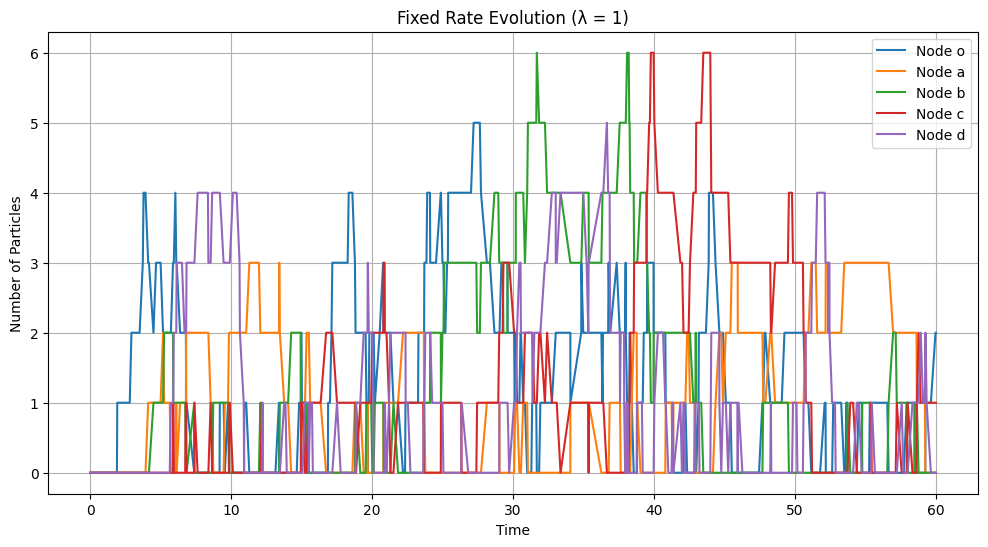

In [86]:
# Fixed rate with λ = 1
fixed_history, fixed_time = simulate_fixed_rate(1, 60)
plot_evolution(fixed_history, fixed_time, 'Fixed Rate Evolution (λ = 1)')


Finding unstable lambda for fixed rate...
Fixed Rate: System becomes unstable at approximately λ = 5.9 (In/Out Ratio > 100)


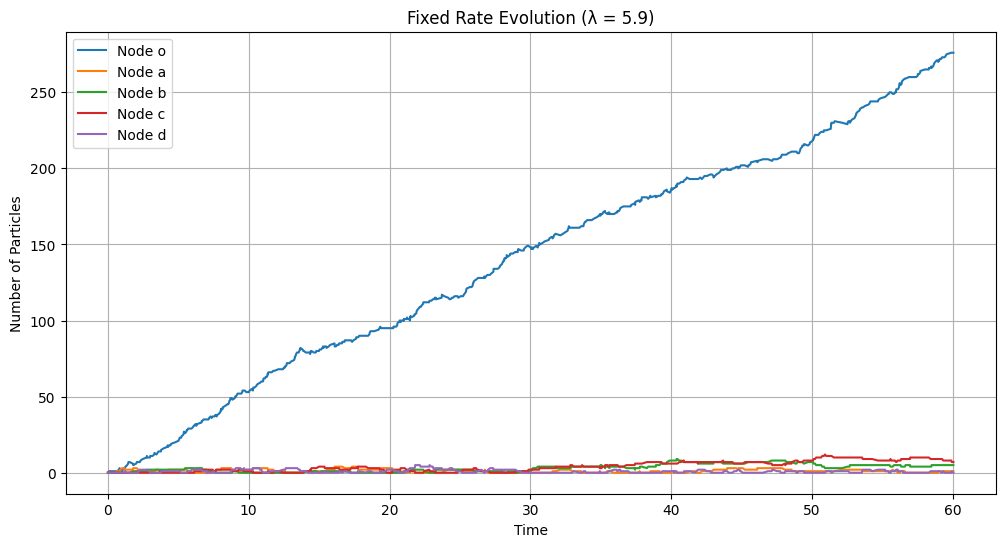

In [ ]:
### Finds the largest input rate for fixed rate before system instability
def find_unstable_lambda_fixed(simulation_time):

    blowup_lambdas = []
    for _ in range(100):
        lambdas = list(range(1, 11))  # Testing λ values from 1 to 10
        for input_rate in lambdas:
            history, time_points = simulate_fixed_rate(input_rate, simulation_time)

            # Count particles entering node 'o' and exiting node 'd'
            particles_in_o = sum(state['o'] for state in history)
            particles_out_d = sum(state['d'] for state in history)

            # Check instability condition
            if particles_out_d > 0 and particles_in_o / particles_out_d > 100:
                blowup_lambdas.append([input_rate])
                break

    avg_blowup_lambda = np.mean(blowup_lambdas)
    print(f"Fixed Rate: System becomes unstable at approximately λ = {avg_blowup_lambda} (In/Out Ratio > 100)")
    history, time_points = simulate_fixed_rate(avg_blowup_lambda, simulation_time)
    plot_evolution(history, time_points, f"Fixed Rate Evolution (λ = {avg_blowup_lambda})")

print("\nFinding unstable lambda for fixed rate...")
find_unstable_lambda_fixed(simulation_time)